# Neural Relational Inference

In this session, we implement the ideas described in https://arxiv.org/pdf/1802.04687.pdf .
Most of the code in the solution has been adapted from https://github.com/ethanfetaya/NRI .

First add this drive folder to your own google drive account :
https://drive.google.com/open?id=10Awx22Z8vah5MxBrCSgQGuQaS2HdG2ae

Then follow these setup instructions. The `ls` should show one data folder and a utils.py file.

In [1]:
## SETUP
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Summer_School
!ls

/content/drive/My Drive/Summer_School
data  __pycache__  utils.py


## Data, baselines and evaluations

In [0]:
from utils import load_data

loaders, location_range, velocity_range = load_data(batch_size=1, suffix='_springs5')

### Plotting the input data

Find a good way to display the input data. Display both the particles and the relation matrix 

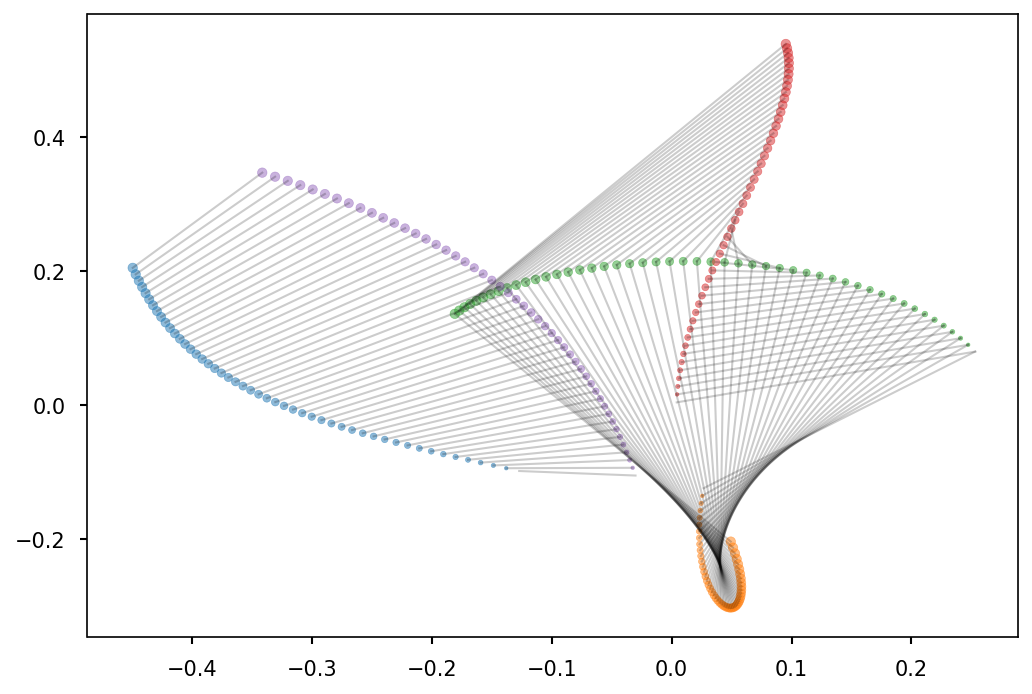

In [4]:
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('seaborn-notebook')
plt.figure(dpi=150)


num_atoms = 5
off_diag_idx = np.ravel_multi_index(
    np.where(np.ones((num_atoms, num_atoms)) - np.eye(num_atoms)),
    [num_atoms, num_atoms]
)
for atoms, edges in loaders['train']:
    # edges contains the off-diagonal elements of the interaction matrix
    interactions = np.reshape(np.zeros((num_atoms, num_atoms)), [-1, 25])
    interactions[0][off_diag_idx] = edges
    interactions = np.reshape(interactions, [5,5])
    # now interactions_{i,j} contains whether or not i and j interact

    # TODO : plot the atoms and their interactions
    timesteps = atoms.shape[2]
    atoms_coord = []
    for atom in range(num_atoms):
        this_atom = []
        for t in range(timesteps):
            datum = atoms[0][atom][t]
            this_atom.append(datum.tolist())
        this_atom = np.array(this_atom)
        plt.scatter(this_atom[:, 0], this_atom[:, 1], s=3*np.sqrt(np.array(range(timesteps))), alpha=0.5)
        atoms_coord.append(this_atom)
    
    for atom_a in range(num_atoms):
        for atom_b in range(atom_a + 1, num_atoms):
            if interactions[atom_a, atom_b] == 1:
                for d1, d2 in zip(atoms_coord[atom_a], atoms_coord[atom_b]):
                    plt.plot(
                        [d1[0], d2[0]],
                        [d1[1], d2[1]],
                        'k-',
                        linewidth = 1,
                        alpha=0.2
                    )
    break
plt.show()

## LSTM Baseline

It's always a good idea to start with "simple" algorithms first. Here we'll start by trying to predict the joint trajectories with an LSTM. To do this, we first map the coordinates to a feature space with an MLP. Then we apply the LSTM in this feature space, before decoding the output of the LSTM to the original coordinates. 

In [0]:
from __future__ import division
from __future__ import print_function

import time
import pickle
import os
import datetime

import torch.optim as optim
from torch.optim import lr_scheduler

suffix = '_springs5'
n_atoms =  5

epochs = 1

n_hidden = 256
n_layers = 2

batch_size = 128
learning_rate = 5e-4
dropout = 0
temp = 0.5

timesteps = 49
prediction_steps = 10
valid_freq = 1

var = 5e-5

loaders, location_range, velocity_range = load_data(batch_size=batch_size, suffix=suffix)

### Model

Complete the following skeleton to implement the LSTM baseline described in the appendix of the paper.
    <ul>
        <li> step: <ul>
            <li>$f_t = \textrm{pos_encoder}(x_t)$</li>
            <li>$\delta, h_{t+1} = \textrm{LSTM}(f_t, h_t)$</li>
            <li>return  $x_{t+1} = x_t + \textrm{pos_decoder}(\delta)$ and $h_{t+1}$</li>
            </ul>
        </li>
        <li> forward: <ul>
            <li>run step for $b$ <em>burn-in</em> steps with true data as input.</li>
            <li>then use the previous prediction as input. </li>
            <li>return full sequence of outputs</li>
            </ul></li>
    </ul>

In [0]:
import torch
from torch import nn
from torch.functional import F

class RecurrentBaseline(nn.Module):
    """LSTM model for joint trajectory prediction."""

    def __init__(self, n_dims, n_hid, n_atoms, n_layers, do_prob=0.):
        super(RecurrentBaseline, self).__init__()
        
        # Encoder from positions to n_hid dimensional space
        # The architecture is linear / relu / dropout(do_prob) / linear / relu
        self.pos_encoder = nn.Sequential(
            nn.Linear(n_dims, n_hid), nn.ReLU(True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_hid), nn.ReLU(True)
        )
        
        # RNN : n_atoms * n_hid -> n_atoms * n_hid. LSTM with n_layers.
        self.rnn = nn.LSTM(n_atoms * n_hid, n_atoms * n_hid, n_layers)  # TODO

        # Decode predicted *joint* configuration to physical *joint* location
        # The architecture is linear / relu / linear
        self.pos_decoder = nn.Sequential(
            nn.Linear(n_atoms * n_hid, n_atoms * n_hid), nn.ReLU(True),
            nn.Linear(n_atoms * n_hid, n_atoms * n_dims)
        )

    def step(self, ins, hidden=None):
        # Input shape: [num_sims, n_atoms, n_dims]
        
        # Apply first MLP to encode the coordinates
        x = self.pos_encoder(ins)
        # View to join the last two dimensions. Add a dummy time dimension at the beginning of x
        x = x.view(ins.shape[0], -1).unsqueeze(0)
        # Apply LSTM given hidden and encoded input
        x, hidden = self.rnn(x, hidden)
        # remove extraneous time dimension
        x = x.squeeze(0)
        # Apply second MLP to decode the output of the LSTM and compute delta
        delta = self.pos_decoder(x)
        # View to separate the last two dimensions again
        delta = delta.view(ins.size(0), ins.size(1), -1)
        # Add delta to inputs
        x = ins + delta

        # Return both output and hidden
        return x, hidden

    def forward(self, inputs, burn_in_steps=1):
        # Input shape: [num_sims, num_things, num_timesteps, n_in]

        outputs = []
        hidden = None

        for step in range(0, inputs.size(2) - 1):
            # If step <= burn_in_steps, the input is the true input
            # Otherwise it's the output of the previous step
            if step <= burn_in_steps:
                ins = inputs[:, :, step, :]
            else:
                ins = outputs[step - 1]

            output, hidden = self.step(ins, hidden)
            outputs.append(output)

        outputs = torch.stack(outputs, dim=2)

        return outputs

### Eval

We use the negative log likelihood as a measure of performance, as in the paper and provided in the github repo. The evaluation code is given.

Fill out the training loop to use the RecurrentBaseline implemented above to minimize this negative log likelihood. Also compute the negative log-likelihood of the predictions after burn-in. 

Notice that the negative log-likelihood is lower after the burn-in than before. Why is this surprising ? Why is this happening ?

Comment on the speed of this baseline. How involved would it be to make it faster ?

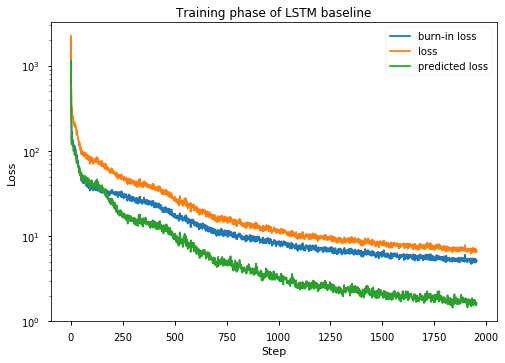

In [0]:
from tqdm import tqdm_notebook, tnrange

model = RecurrentBaseline(4, 256, 5, 2, 0.2).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def nll_gaussian(preds, target, variance):
    neg_log_p = ((preds - target) ** 2 / (2 * variance))
    return neg_log_p.sum() / (target.size(0) * target.size(1))

# One epoch of training
def train(epoch):
    t = time.time()
    burn_in_loss = []
    loss = []
    pred_loss = []
    model.train()
    with tqdm_notebook(loaders['train'], desc=f'training') as t:
        for data, relations in t:
            data, relations = data.cuda(), relations.cuda()
            # compute the predicted trajectory with burn_in = timesteps - prediction_steps
            output = model(data, burn_in_steps=timesteps-prediction_steps)
            # output_t is data_{t+1}. Select a time-shifted slice of target to make loss computations easier
            target = data[:, :, 1:, :]
            
            # Compute the training loss and nll on steps after burn in
            bi_loss = nll_gaussian(output[:, :, :-prediction_steps, :], target[:, :, :-prediction_steps, :], var)
            l = nll_gaussian(output, target, var)
            predicted_loss = nll_gaussian(output[:, :, -prediction_steps:, :], target[:, :, -prediction_steps:, :], var)

            # take a gradient step
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            burn_in_loss.append(bi_loss.item())
            loss.append(l.item())
            pred_loss.append(predicted_loss.item())
            
            t.set_postfix(loss=l.item(), pred=predicted_loss.item())

    # return average loss and pred_loss
    return burn_in_loss, loss, pred_loss  # np.mean(loss), np.mean(pred_loss)

burn_in_loss = []
nlls = []
pred_losses = []
# Train model
for epoch in tnrange(5):
    bi_loss, nll, pred_loss = train(epoch)
    burn_in_loss += bi_loss
    nlls += nll
    pred_losses += pred_loss


plt.figure()
plt.title('Training phase of LSTM baseline')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

plt.plot(np.array(burn_in_loss), label='burn-in loss')
plt.plot(np.array(nlls), label='loss')
plt.plot(np.array(pred_losses), label='predicted loss')

plt.legend(loc='best')
plt.show()

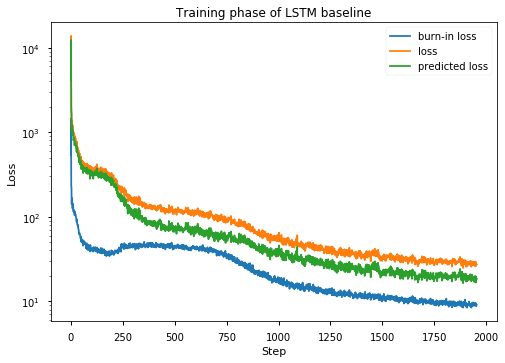

In [0]:
plt.figure()
plt.title('Training phase of LSTM baseline')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

plt.plot(np.array(burn_in_loss), label='burn-in loss')
plt.plot(np.array(nlls), label='loss')
plt.plot(np.array(pred_losses), label='predicted loss')

plt.legend(loc='best')
plt.show()

## Neural Relational Inference model

There are two parts to the model : an encoder that estimates the relation matrix and a decoder that produces a sequence given an estimation of the relation matrix.

### The encoder
The equations for the encoder in the paper are :
$${\bf h}^1_j = f_{emb}({\bf x}_j)$$
$$v\rightarrow e:\quad {\bf h}^1_{(i,j)} = f_e^1([{\bf h}^1_i, {\bf h}^1_j])$$
$$e\rightarrow v:\quad{\bf h}^2_j = f_v^1\big(\sum_{i \neq j}{\bf h}^1_{(i,j)}\big)$$
$$v\rightarrow e:\quad{\bf h}^2_{(i,j)} = f_e^2([{\bf h}_i^2, {\bf h}_j^2])$$

Finally, we do a logistic regression on ${\bf h}^2_{(i,j)}$ to obtain the probabilities of edge / non-edge.

We will represent all functions as multi-layer perceptrons.

The implementation challenge in the encoder is to efficiently concatenate the $h_i$, $h_j$. We do this using ```index_select(input, dim, indices)```.

Given an input of dimension $atoms \times d$, create two index tensors such that for
```python
    x = torch.index_select(input, 0, id1)
    y = torch.index_select(input, 0, id2)
```
We have $x_{i*atoms + j} = input_i$ and $x_{i*atoms + j} = input_j$. 

In [0]:
n_atoms = 5
d = 2
features = torch.FloatTensor([[i] * d for i in range(n_atoms)])

id1 = torch.LongTensor(sum([[i] * n_atoms for i in range(n_atoms)], []))
id2 = torch.LongTensor(sum([list(range(n_atoms)) for i in range(n_atoms)], []))

In [8]:
print(features)
print(id1, id2)

tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.]])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4]) tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
        4])


We can now easily write the concatenation in the $v\rightarrow e$ step:

In [9]:
def v_to_e(x, id1, id2):
    return torch.cat([
        torch.index_select(x, 0, id1),
        torch.index_select(x, 0, id2),
    ], 1)

print(v_to_e(features, id1, id2))

tensor([[0., 0., 0., 0.],
        [0., 0., 1., 1.],
        [0., 0., 2., 2.],
        [0., 0., 3., 3.],
        [0., 0., 4., 4.],
        [1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 2., 2.],
        [1., 1., 3., 3.],
        [1., 1., 4., 4.],
        [2., 2., 0., 0.],
        [2., 2., 1., 1.],
        [2., 2., 2., 2.],
        [2., 2., 3., 3.],
        [2., 2., 4., 4.],
        [3., 3., 0., 0.],
        [3., 3., 1., 1.],
        [3., 3., 2., 2.],
        [3., 3., 3., 3.],
        [3., 3., 4., 4.],
        [4., 4., 0., 0.],
        [4., 4., 1., 1.],
        [4., 4., 2., 2.],
        [4., 4., 3., 3.],
        [4., 4., 4., 4.]])


Read and understand this implementation of the aggregation in the $e \rightarrow v$ step.

What differs in this implementation from the equation above ?

In [0]:
aggregator = torch.FloatTensor([
    [1./n_atoms if row * n_atoms <= col < (row + 1) * n_atoms else 0 for col in range(n_atoms * n_atoms)]
    for row in range(n_atoms)
])

def e_to_v(x, matrix):
    return matrix @ x

In order to remove self-loops, we will use another index select. Given a tensor resulting from the v\_to\_e function above, write a function using index select that returns all edges except self edges. 

In [11]:
id3 = []
for i in range(n_atoms):
    for j in range(n_atoms):
        if i != j :
            id3.append(i * n_atoms + j) 
id3 = torch.LongTensor(id3)

def remove_self_edges(features):
    return torch.index_select(features, 0, id3)

print(remove_self_edges(v_to_e(features, id1, id2)))

tensor([[0., 0., 1., 1.],
        [0., 0., 2., 2.],
        [0., 0., 3., 3.],
        [0., 0., 4., 4.],
        [1., 1., 0., 0.],
        [1., 1., 2., 2.],
        [1., 1., 3., 3.],
        [1., 1., 4., 4.],
        [2., 2., 0., 0.],
        [2., 2., 1., 1.],
        [2., 2., 3., 3.],
        [2., 2., 4., 4.],
        [3., 3., 0., 0.],
        [3., 3., 1., 1.],
        [3., 3., 2., 2.],
        [3., 3., 4., 4.],
        [4., 4., 0., 0.],
        [4., 4., 1., 1.],
        [4., 4., 2., 2.],
        [4., 4., 3., 3.]])


#### MLP Encoder

Let's hide this all inside a neat MLPEncoder class. An MLP class is given that will be used for all function approximation within this encoder.

`ids_and_agg` returns (id1, id2, agg, id3) where id1 and id2 are used for tiling the features in the v->e step. agg is the same aggregator as before except if no_self_edges is true, in which case it doesn't aggregate the self-edges. Finally, id3 is the index used for removing self-edges from the v->e step.

Complete the MLPEncoder class below, to match the equations of the encoder above.

**Note** : Compared to the equations above, we add a skip connection from the output of equation 2 to the input of equation 4 (ie, $f_e^2$ acts on the concatenation of $[{\bf h}_i^2, {\bf h}_j^2]$ and ${\bf h^1_{(i,j)}}$)

In [0]:
import torch.nn.functional as F

class MLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn = nn.BatchNorm1d(n_out)
        self.dropout_prob = do_prob

    def batch_norm(self, inputs):
        x = inputs.view(inputs.size(0) * inputs.size(1), -1)
        x = self.bn(x)
        return x.view(inputs.size(0), inputs.size(1), -1)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = F.elu(self.fc1(inputs))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.elu(self.fc2(x))
        return self.batch_norm(x)


def ids_and_agg(n_atoms, no_self_edges=False):
    n_for_agg = (n_atoms - 1) if no_self_edges else n_atoms
    return (
        torch.cuda.LongTensor(sum([[i] * n_atoms for i in range(n_atoms)], [])),
        torch.cuda.LongTensor(sum([list(range(n_atoms)) for i in range(n_atoms)], [])),
        torch.cuda.FloatTensor([
            [1. / n_for_agg if row * n_for_agg <= col < (row + 1) * n_for_agg else 0
             for col in range(n_for_agg * n_atoms)]
            for row in range(n_atoms)
        ]),
        torch.cuda.LongTensor([
            i for i in range(n_atoms * n_atoms)
            if i not in set([j*n_atoms + j for j in range(n_atoms)])
        ])
    )


class MLPEncoder(nn.Module):
    def __init__(self, n_atoms, n_in, n_hid, n_out, do_prob=0.):
        """
        Given an input of shape [batch_size, num_atoms, num_timesteps, num_dims],
        output a tensor of shape [num_atoms * (num_atoms - 1), n_out] with class logits for each atom-atom interaction edge.
        
        :param n_atoms number of atoms in the simulation
        :param n_in total number of features for one atom, ie, n_dim * n_timesteps
        :param n_hid size of the hidden layer
        :param n_out number of classes to output for the encoder (ie, edge types)
        """
        super(MLPEncoder, self).__init__()
        # mlp1 is f_emb
        self.mlp1 = MLP(n_in, n_hid, n_hid, do_prob)
        # mlp2 is f_e^1 
        self.mlp2 = MLP(2 * n_hid, n_hid, n_hid, do_prob)
        # mlp3 is f_v^1
        self.mlp3 = MLP(n_hid, n_hid, n_hid, do_prob)
        # mlp4 is f_e^2
        self.mlp4 = MLP(3 * n_hid, n_hid, n_hid, do_prob)
        # fc_out to output the logits of each interaction class
        self.fc_out = nn.Linear(n_hid, n_out)
        
        self.id1, self.id2, self.aggregator, self.id3 = ids_and_agg(n_atoms)

    def tile(self, x):
        # v -> e
        return torch.cat([
            torch.index_select(x, 1, self.id1),
            torch.index_select(x, 1, self.id2),
        ], 2)

    def aggregate(self, x):
        # e -> v
        return self.aggregator @ x

    def forward(self, inputs):
        # Input shape: [num_sims, num_atoms, num_timesteps, num_dims]
        x = inputs.view(inputs.size(0), inputs.size(1), -1)
        # New shape: [num_sims, num_atoms, num_timesteps*num_dims]
        
        x = self.mlp1(x)                                         # eq 1
        x_skip = self.mlp2(self.tile(x))                         # eq 2
        x = self.mlp3(self.aggregate(x_skip))                    # eq 3
        x = self.mlp4(torch.cat((self.tile(x), x_skip), dim=2))  # eq 4
        
        logits = self.fc_out(x)
        return torch.index_select(logits, 1, self.id3)  # remove self-edges

Before adding the decoder, let's verify that this MLP Encoder can at least overfit the training data.

The function edge_accuracy computes the argmax of the logits along the last dimension of `preds` (either 0 or 1 for two classes), and returns the proportion of correct classifications compared to `target`.

Complete the following code to train your encoder to match the relations in the train set. After two epochs, you should reach train accuracies above 0.95

In [13]:
from tqdm import tqdm_notebook, tnrange
from torch.nn import BCEWithLogitsLoss
n_atoms = 5
model = MLPEncoder(n_atoms, int(4 * timesteps), 256, 2, 0.2).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def edge_accuracy(preds, target):
    """
    :param preds: edge logits
    :param target: ground truth
    :return: precision of the prediction
    """
    _, preds = preds.max(-1)
    correct = preds.float().data.eq(
        target.float().data.view_as(preds)).cpu().sum()
    return np.float(correct) / (target.size(0) * target.size(1))

# One epoch of training
def train(epoch):
    t = time.time()
    loss_train = []
    acc_train = []
    # pick the right loss
    loss = nn.BCEWithLogitsLoss(reduction='mean')
    model.train()
    with tqdm_notebook(loaders['train'], 'training') as t:
        for data, relations in t:
            data, relations = data.cuda(), relations.cuda()
            # compute the loss and take a gradient step
            logits = model(data)
            l = loss(
                logits,
                torch.cat((
                    (relations == 0)[:,:, None],
                    (relations == 1)[:,:, None]
                ), 2).float()
            )

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            # compute the accuracy
            edge_acc = edge_accuracy(logits, relations)
            
            loss_train.append(l.item())
            acc_train.append(edge_acc)
            
            t.set_postfix(loss=l.item(), acc=edge_acc)

    return np.mean(loss_train), np.mean(acc_train)

# Train model
t_total = time.time()
best_epoch = 0
for epoch in tnrange(2):
    train_loss, train_acc = train(epoch)

### The decoder

The equations of the recurrent decoder are :
$$
\begin{aligned} v \rightarrow e : \tilde{\mathbf{h}}_{(i, j)}^{t} &=\sum_{k} z_{i j, k} \tilde{f}_{e}^{k}\left(\left[\tilde{\mathbf{h}}_{i}^{t}, \tilde{\mathbf{h}}_{j}^{t}\right]\right) \\ e \rightarrow v : \operatorname{MSG}_{j}^{t} &=\sum_{i \neq j} \tilde{\mathbf{h}}_{(i, j)}^{t} \\ \tilde{\mathbf{h}}_{j}^{t+1} &=\operatorname{GRU}\left(\left[\operatorname{MSG}_{j}^{t}, \mathbf{x}_{j}^{t}\right], \tilde{\mathbf{h}}_{j}^{t}\right) \\ \boldsymbol{\mu}_{j}^{t+1} &=\mathbf{x}_{j}^{t}+f_{\text { out }}\left(\tilde{\mathbf{h}}_{j}^{t+1}\right) \\ p\left(\mathbf{x}^{t+1} | \mathbf{x}^{t}, \mathbf{z}\right) &=\mathcal{N}\left(\boldsymbol{\mu}^{t+1}, \sigma^{2} \mathbf{I}\right) \end{aligned}
$$

We will use only one edge type (ie 2 classes, _on_ or _off_) for simplicity.

The last equation describes the likelihood of one point, by optimizing the nll_gaussian, we ensure that this probability is high on the train set.

Complete the following skeleton code for the `RNNDecoder` module.

In [0]:
class RNNDecoder(nn.Module):
    """Recurrent decoder module."""

    def __init__(self, n_dims, n_hid, do_prob=0.):
        super(RNNDecoder, self).__init__()
        
        # Linear, Tanh, Dropout, Linear, Tanh
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * n_hid, n_hid), nn.Tanh(), nn.Dropout(do_prob),
            nn.Linear(n_hid, n_hid), nn.Tanh()
        )
        
        # GruCell
        self.gru = nn.GRUCell(input_size=n_dims, hidden_size=n_hid)
        
        # Linear, ReLU, Linear, ReLU, Linear
        self.decoder = nn.Sequential(
            nn.Linear(n_hid, n_hid), nn.ReLU(),
            nn.Linear(n_hid, n_hid), nn.ReLU(),
            nn.Linear(n_hid, n_dims)
        )
        self.n_dims = n_dims
        self.n_hid = n_hid
        
        self.id1, self.id2, self.aggregator, self.id3 = ids_and_agg(n_atoms, True)
        
    def step(self, inputs, edges, hidden):
        """
        Compute one step of the decoder
        :param inputs: a tensor of shape [batch_size x n_atoms x dims]
        :param edges: a tensor of shape  [batch_size x n_edges x edge_type]
        :param hidden: a tensor of shape [batch_size x n_atoms x hidden_size]
        """
        # concatenate the features (equation 1)
        hidden_state = torch.cat([
            torch.index_select(hidden, 1, self.id1),
            torch.index_select(hidden, 1, self.id2)
        ], 2)
        # remove the self edges
        hidden_without_self = torch.index_select(hidden_state, 1, self.id3)
        # multiply by the z, the probability that the edge is active
        transformed = self.edge_mlp(hidden_without_self) * edges[:,:, 1].unsqueeze(2)
        # aggregate
        hidden_state = self.aggregator @ transformed
        
        # compute the next_hidden state with the gru
        next_hidden = self.gru(
            inputs.contiguous().view(-1, self.n_dims),
            hidden_state.view(-1, self.n_hid)
        ).reshape(hidden.shape)
        
        # compute the output
        output = self.decoder(next_hidden) + inputs

        return output, next_hidden

    def forward(self, data, edges, burn_in_steps=1):

        inputs = data.transpose(1, 2).contiguous()

        time_steps = inputs.size(1)

        hidden = torch.zeros(inputs.size(0), inputs.size(2), self.n_hid).cuda()
        pred_all = []

        for step in range(inputs.size(1) - 1):
            # similar as for the LSTM baseline
            if step <= burn_in_steps:
                ins = inputs[:, step, :, :]
            else:
                ins = pred_all[step - 1]

            pred, hidden = self.step(ins, edges, hidden)
            pred_all.append(pred)

        preds = torch.stack(pred_all, dim=1)

        return preds.transpose(1, 2)

### Minimizing the negative ELBO

Our goal is to minimize the following loss :
$$
\mathcal{L}=-\mathbb{E}_{q_{\phi}(\mathbf{z} | \mathbf{x})}\left[\log p_{\theta}(\mathbf{x} | \mathbf{z})\right]+\mathrm{KL}\left[q_{\phi}(\mathbf{z} | \mathbf{x}) \| p_{\theta}(\mathbf{z})\right]
$$

Following the paper, we first encode the trajectory to obtain $q_\phi(z|x)$. Instead of sampling from the logits, we use the gumbel_softmax to obtain backpropable edge probabilities.

With these edge probabilities $z$, we use our rnn decoder and the nll_gaussian to compute the likelihood of $x$ given $z$.

Complete the following code, which implements the method described in the Neural Relational Inference paper.

### Putting it all together

What do you notice about the edge accuracy during training ? Why is this surprising ? 

In [17]:
from torch.nn.functional import gumbel_softmax, softmax

def kl_categorical_uniform(preds, num_atoms):
    """
    :param preds tensor of shape [n_edge x 2] containing the probabilities of no edge and edge in columns 0 and 1.
    """
    kl_div = preds * torch.log(preds + 1e-16)
    return kl_div.sum() / (num_atoms * preds.size(0))

def train(data_loader, optimizer, encoder, decoder):
    loss_train = []
    edge_accuracies = []

    encoder.train()
    decoder.train()
    with tqdm_notebook(data_loader, desc=f'training') as t:
        for data, relations in t:
            data, relations = data.cuda(), relations.cuda()     

            # Encode
            logits = encoder(data)

            # Compute edges with soft gumbel_softmax
            edges = gumbel_softmax(
                logits.view(-1, 2), tau=temp, hard=False
            ).view(logits.shape)

            # Decode using the edge weights
            output = decoder(
                data, edges, burn_in_steps=timesteps-prediction_steps
            )

            nll = nll_gaussian(
                output, data[:, :, 1:, :], var
              )
            kl = kl_categorical_uniform(
              softmax(logits, 2), output.shape[1]
            )
            l = nll + kl
            
            # Compute edge accuracy
            edge_acc = edge_accuracy(logits, relations)
            edge_accuracies.append(edge_acc)

            # Gradient step
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            loss_train.append(l.item())
            t.set_postfix(loss=l.item(), nll = nll.item(), kl = kl.item(), acc=edge_acc)
        
    return np.mean(loss_train), edge_accuracies

dropout = 0
n_dims = 4
hidden = 256

encoder = MLPEncoder(num_atoms, int(n_dims * timesteps), hidden, 2, dropout).cuda()
decoder = RNNDecoder(n_dims, hidden, dropout).cuda()

optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=learning_rate
)

edge_accuracies = []
for e in range(10):
    loss, edge_accs = train(loaders['train'], optimizer, encoder, decoder)
    edge_accuracies += edge_accs
    print(f"{loss}")


274.3907734805056



38.23015667166551



27.871067759326046



24.26018251482483



20.996071252066766



19.080985466842456



16.31450018187618



14.720250865077729



13.134049331440645



12.111813875720324


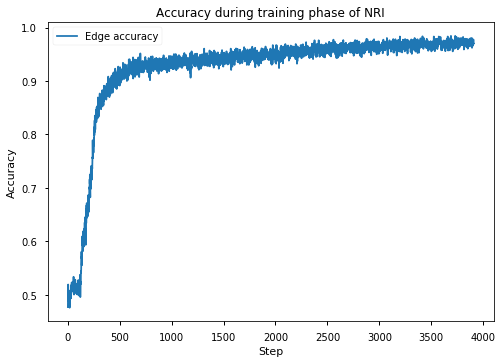

In [19]:
plt.figure()
plt.title('Accuracy during training phase of NRI')
plt.xlabel('Step')
plt.ylabel('Accuracy')

plt.plot(np.array(edge_accuracies), label='Edge accuracy')

plt.legend(loc='best')
plt.show()

### Bonus
On the test set, plot the predicted trajectories for a few inputs. Differentiate the burn-in phase and pure prediction phase. Also plot the true trajectories and compare.